# Spatial properties of the flood event and the influence of true distance travelled on water quality

## The code is used to iterate through 2 week passive tracers of the flood event to ascertain a better understanding of the spatial deveopment of the flood and variables which are known to affect reef health

To do this:
1. Using a variable of interest, iterate through starting dates for the flood event from 7 prior to 7 days after the event peak
        Remember: Event peak = 2019-02-09
                  Store maps of Passive Tracing
                  Store graphs of Distance v Passive Tracing Values
                  Extract correlation between Distance & Passive Tracing Values
                 
2. Repeat this for other variables of interest    

parcel values before execution: [1.940696, 1.9400764, 1.8134546, 1.3204668, 1.1829114, 1.1472192, 1.9592131, 1.9942589, 1.9454271, 1.9530382, 1.9492624, 1.8434564, 1.8441483, 1.9462355, 1.6954286, 1.3949494, 1.4384242, 1.2992373, 1.241335, 1.2433021, 1.1659167, 1.1965742, 1.1969585, 1.151186, 1.9892124, 2.0150332, 1.9673626, 2.0424259, 1.9550283, 1.9487765, 1.9665241, 1.897767, 1.9758552, 1.7601883, 1.8420303, 1.9289851, 1.7526101, 1.9626961, 1.6511028, 1.5131377, 1.5422155, 1.4255532, 1.5966073, 1.3473676, 1.3206117, 1.3315187, 1.2613282, 1.357765, 1.2118906, 1.2727315, 1.2893121, 1.2198565, 1.3067281, 1.1773777]


INFO: Compiled SampleParticleAdvectionRK4SampleT ==> /tmp/parcels-229031/49dd9a9fda82c4283b8cc04f75e77707_0.so


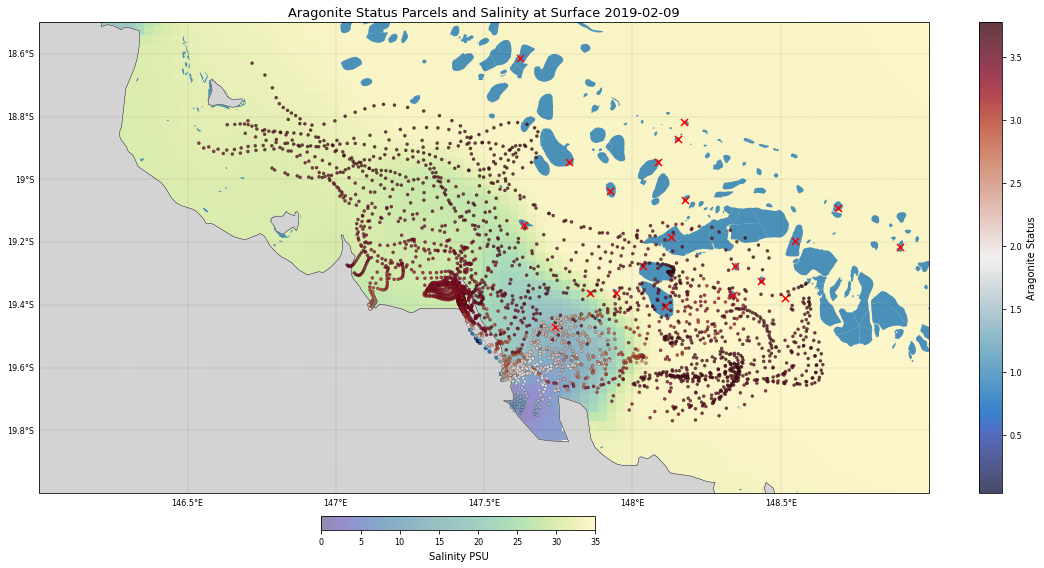

<Figure size 432x288 with 0 Axes>

In [2]:
#----------------------------------------------------------
#____CREATE PASSIVE TRACER FOR SPECIFIED VARIABLE____
#----------------------------------------------------------

import os
import numpy as np
import xarray as xr

import cmocean

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import geopandas as gpd
import pandas as pd

from parcels import FieldSet, Field, ParticleSet, Variable, JITParticle
from parcels import AdvectionRK4, plotTrajectoriesFile, ErrorCode

import math
from datetime import timedelta
from operator import attrgetter

import csv

from matplotlib import pyplot as plt
#%config InlineBackend.figure_format = 'retina'
#plt.ion()  # To trigger the interactive inline mode
%matplotlib inline

#-------------------------------------------------------------------------------preperation of the data to process
# Defining the boundaries
min_lon = 146     # lower left longitude
min_lat = -20     # lower left latitude
max_lon = 149     # upper right longitude
max_lat = -18.5     # upper right latitude
lon_bnds = [min_lon, max_lon]
lat_bnds = [min_lat, max_lat]

starttimes = [0]

ParticleCoords = pd.read_csv("211010_rParticles.csv")
lat11 = ParticleCoords.Lat.tolist()
lon11 = ParticleCoords.Long.tolist()

ds_hydro_clip = xr.open_mfdataset('hydro_region_2019_02.nc')
ds_bio_clip = xr.open_mfdataset('bio_region_2019_02.nc')



min_time = '2019-02-09'     # Put start date here for iterating, flood peak is 2019-02-09
                            # The kernel must be restarted to process different start dates
#---------------------------------------------------------------------------^^^^^^^INPUT START DATE ABOVE^^^^^^^^
max_time = '2019-03-07'     # Max date for netcdf clip
time_bnds = [min_time, max_time]

# Both these netcdfs have already been clipped to the AOI and use only the k = -1 layer
ds_hydro_clip = ds_hydro_clip.sel(time=slice(*time_bnds))
ds_bio_clip = ds_bio_clip.sel(time=slice(*time_bnds))



# cutout unused variables
salt_data2 = ds_hydro_clip.drop(['mean_cur'])
bio_data2 = ds_bio_clip.drop(['DIC','PH','CS_Chl','Chl_a_sum'])
#---------------------------------------------------------------------------^^^^^^^INPUT UNUSED VARIABLES ABOVE^^^^^^^^


data_name ='salt_feb2019.nc'
try:
    os.remove(data_name)
except OSError:
    pass
salt_data2.to_netcdf(path=data_name)

data_name2 ='bio_feb2019.nc'
try:
    os.remove(data_name2)
except OSError:
    pass
bio_data2.to_netcdf(path=data_name2)



def DeleteParticle(particle, fieldset, time):
    particle.delete()
    


filenames = {'U': data_name,
             'V': data_name,
            }

variables = {'U': 'u',
             'V': 'v',
            }

dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, field_chunksize=False)


# use data_name2 section for bio variable parcels
# ---------------------------------------------------------
filenames = {'lat': data_name2,
             'lon': data_name2,
             'data': data_name2}

variable = ('S', 'omega_ar')
#---------------------------------------------------------------------------^^^^^^^INPUT BIO VARIABLE ABOVE ^^^^^^^^

# alternatively, use this data_name section below if choosing to map salt parcels
# ---------------------------------------------------------
# filenames = {'lat': data_name,
#              'lon': data_name,
#              'data': data_name}
# variable = ('S', 'salt')
#---------------------------------------------------------------------------^^^^^^^INPUT HYDRO VARIABLE ABOVE ^^^^^^^^

dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

field = Field.from_netcdf(filenames, variable, dimensions, field_chunksize=False)
fieldset.add_field(field)



class SampleParticle(JITParticle):          # Define a new particle class
    s = Variable('s', initial=fieldset.S)   # Variable 's' initialised by sampling the selected variable
    
       

pset = ParticleSet.from_list(fieldset=fieldset, pclass=SampleParticle, 
                             lon=lon11,   # releasing from a list
                             lat=lat11,   # releasing from a list
                             time=starttimes)

print('parcel values before execution:', [p.s for p in pset])



def SampleT(particle, fieldset, time):    # Custom function that samples fieldset.S at particle location
    particle.s = fieldset.S[time, particle.depth, particle.lat, particle.lon]

k_sample = pset.Kernel(SampleT)           # Casting the SampleT function to a kernel.



output_nc_variable = 'CurrentParticlesVariable.nc'
try:
    os.remove(output_nc_variable)
except OSError:
    pass



output_file_parcels = pset.ParticleFile(name=output_nc_variable, 
                                outputdt=timedelta(hours=6))

pset.execute(AdvectionRK4 + k_sample,    # Add kernels using the + operator.
             runtime=timedelta(days=14),
             dt=timedelta(minutes=5),
             output_file=output_file_parcels,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

output_file_parcels.export()



parcels_temp = xr.open_dataset(output_nc_variable)
parcels_temp



# --------------------------------
# ____NOW TO GRAPH THE RESULTS____
#--------------------------------------------------------------------------read in GBR shapefile
gdf = gpd.read_file("shapefile uploading/Great_Barrier_Reef_Features.shp")
# only extract data that relates to reefs 
reef = gdf['FEAT_NAME'] == "Reef"
reef = gdf[reef]

#--------------------------------------------------------------------------read in reef list csv
reef_locations = pd.read_csv("210913_Reef List.csv")
reef_locations = gpd.GeoDataFrame(reef_locations, 
                    geometry=gpd.points_from_xy(reef_locations.Long, reef_locations.Lat), 
                    crs=reef.crs)

#--------------------------------------------------------------------------create plot
# Figure size
size = (16, 8)

# Color from cmocean
color = cmocean.cm.haline

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())

# We plot the salt at the surface at 1 day following parcel release for comparison
cf = ds_hydro_clip.salt.isel(time=1).plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0, vmax = 35, alpha=0.5, 
    add_colorbar=False)

# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                    orientation="horizontal")
cbar.set_label(ds_hydro_clip.salt.long_name+' '+ds_hydro_clip.salt.units, rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

#--------------------------------------------------------------------------include GBR shapefile plot
ax2 = reef.plot(ax=ax,alpha = 0.8)

#--------------------------------------------------------------------------include reef locations plot
ax3 = reef_locations.plot(ax=ax, marker='x', color='red', markersize=50)

#--------------------------------------------------------------------------Plot formatting
# Title
plt.title('Aragonite Status Parcels and Salinity at Surface '+min_time,
          fontsize=13
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=0.4)

#-------------------------------------------------------------------------choose vmax vmin for parcel scale
Varmin = parcels_temp.s.min().item()
Varmax = parcels_temp.s.max().item()
# saltmin = 0
# saltmax = 35
# Armin = 1
# Armax = 4
# CSmin = -0.5
# CSmax = 0.5
# PHmin = 7.8
# PHmax = 8.2
# DICmin = 10000
# DICmax = 25000
# Chlmin = 0
# Chlmax = 1

for k in range(parcels_temp.lon.shape[0]):
    sc = plt.scatter(parcels_temp.lon.isel(traj=k), parcels_temp.lat.isel(traj=k), s=10, 
               c=parcels_temp.s.isel(traj=k), edgecolors='k', 
               cmap=cmocean.cm.balance, vmin=Varmin, vmax=Varmax, 
               linewidth=0.2, transform=ccrs.PlateCarree(),alpha=0.8).set_zorder(11)

#-------------------------------------------------------------------------plot parcel scale bar
# Color bar
cbar2 = plt.colorbar(sc, ax=ax, fraction=0.027, pad=0.045)
cbar2.set_label('Aragonite Status', rotation=90, 
               labelpad=5, fontsize=10)
cbar2.ax.tick_params(labelsize=8)

#--------------------------------------------------------------------------save image
# plt.savefig(f"Images/Particles_Ar_02_09.png",dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()
fig.clear()
plt.close(fig)
plt.clf()

## Spatial Development of Flood Parcels and Aragonite Status

This passive tracing map has been produced using a release date of 2019-02-09 and tracing Aragonite Status

The underlying Salinity map is produce using the Ereefs Biogeochemical Model on the release date to indicate the projection of the flood plume

Note the visual correlation between low salinity and low Aragonite Status associated with the flood plume

Clearly reef locations in the mid shelf are affected by the flood plume, particularly so for those on the western side of the shelf bordering the lagoon. The image would suggest that the eastern front of the plume may have the most significant effect on Aragonite Status at reef sites in this region.

Additionally note the high rate of mixing of Aragonite Status for tracing parcels

INFO: Compiled DistParticleAdvectionRK4TotalDistance ==> /tmp/parcels-229031/0ec9b035a9d33aa1253cb192fb0d93e0_0.so


[41.930378, 46.202652, 72.75612, 257.83408, 240.79715, 231.74818, 55.00158, 49.321728, 42.321877, 55.015285, 46.056625, 44.836388, 184.11398, 90.51025, 190.56422, 263.46826, 285.47433, 273.8337, 284.15457, 260.16446, 232.30862, 232.57866, 189.59984, 227.64253, 87.49747, 86.83846, 98.207344, 99.37568, 72.06308, 129.94714, 87.857056, 120.45387, 100.20904, 238.50931, 292.30423, 226.0234, 273.73572, 190.29355, 260.83777, 270.39145, 260.53818, 271.07086, 288.12546, 261.1344, 273.83066, 260.1554, 239.17131, 255.49794, 229.44444, 239.92503, 290.74503, 228.98155, 263.8433, 224.2165]


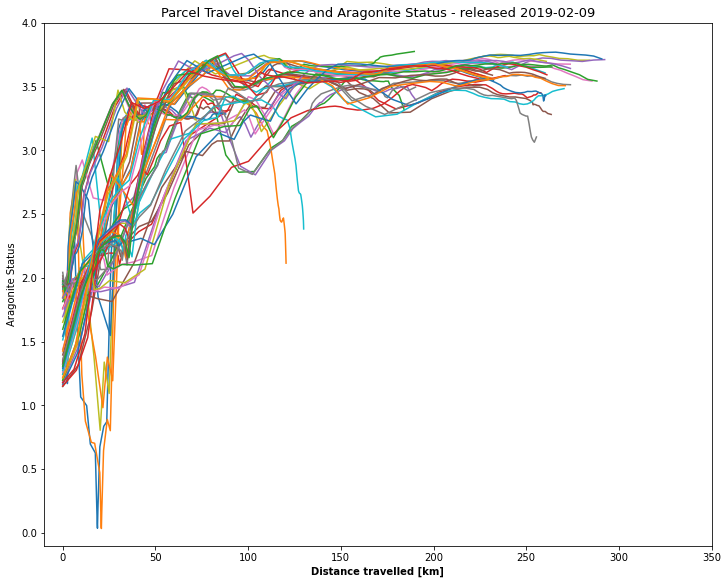

In [3]:
#----------------------------------------------------------
#____CALCULATE DISTANCES TRAVELLED____
#----------------------------------------------------------

class DistParticle(JITParticle):  # Define a new particle class that contains three extra variables
    
    distance = Variable('distance', initial=0., dtype=np.float32)  # the distance travelled
    prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False,
                        initial=attrgetter('lon'))  # the previous longitude
    prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False,
                        initial=attrgetter('lat'))  # the previous latitude.
 
    
    
def TotalDistance(particle, fieldset, time):
    
    # Calculate the distance in latitudinal direction (using 1.11e2 kilometer per degree latitude)
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    # Calculate the distance in longitudinal direction, using cosine(latitude) - spherical earth
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi / 180)
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))

    particle.prev_lon = particle.lon  # Set the stored values for next iteration.
    particle.prev_lat = particle.lat
    
    
        
filenames = {'U': data_name,
             'V': data_name,
            }

variables = {'U': 'u',
             'V': 'v'}

dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

pset = ParticleSet.from_list(fieldset=fieldset, pclass=DistParticle, 
                             lon=lon11,   # releasing on a line: the start longitude and latitude
                             lat=lat11,  # releasing on a line: the end longitude and latitude
                             time=starttimes)

k_dist = pset.Kernel(TotalDistance)  # Casting the TotalDistance function to a kernel.



output_nc_dist = 'CurrentParticlesDist.nc'
try:
    os.remove(output_nc_dist)
except OSError:
    pass

file_dist = pset.ParticleFile(name=output_nc_dist, 
                                outputdt=timedelta(hours=6))


pset.execute(AdvectionRK4 + k_dist,  # Add kernels using the + operator.
             runtime=timedelta(days=14),
             dt=timedelta(minutes=5),
             output_file=file_dist,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

file_dist.export()



print([p.distance for p in pset]) # the distances in km travelled by the particles



parcels_dist = xr.open_dataset(output_nc_dist)
parcels_dist



#---------------------------------------------------------
#____NOW GRAPH THE VARIABLE AGAINST DISTANCE TRAVELLED____
#---------------------------------------------------------

fig,(ax1) = plt.subplots(figsize=(10,8),constrained_layout=True)

ax1.set_ylabel('Aragonite Status')
ax1.set_xlabel('Distance travelled [km]',weight='bold')
ax1.set_xlim([-10, 350])
ax1.set_ylim([-0.1, 4]) # input suitable range for different variables (note Varmin Varmax section in previous cell)
d_plot = ax1.plot(parcels_dist.distance.transpose(),parcels_temp.s.transpose())

plt.title('Parcel Travel Distance and Aragonite Status - released '+min_time,
          fontsize=13
         )

#--------------------------------------------------------------------------save image
# plt.savefig(f"Images/Distance_Ar_02_09.png",dpi=300, bbox_inches='tight')

plt.show()

## Graphing the Behaviour of Aragonite Status Over Distance Travelled

In general this seems to follow a logarithmic relationship

Abnormalities exist relatign to parcels values which may be influenced by near shore travel (and additional inputs of river discharge) seen in the previous map

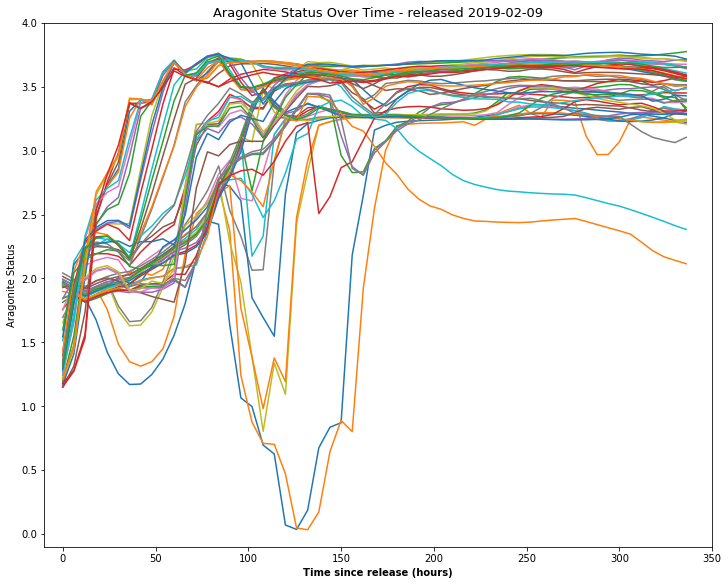

In [4]:
#-------------------------------------------
#____NOW GRAPH THE VARIABLE AGAINST TIME____
#-------------------------------------------

time_since_release = (parcels_dist.time.transpose() - parcels_dist.time[:,0])
time2 = time_since_release/3.6e+12 #hours

fig,(ax1) = plt.subplots(figsize=(10,8),constrained_layout=True)

ax1.set_ylabel('Aragonite Status')
ax1.set_xlabel('Time since release (hours)',weight='bold')
ax1.set_xlim([-10, 350])
ax1.set_ylim([-0.1, 4])
d_plot = ax1.plot(time2,parcels_temp.s.transpose())

plt.title('Aragonite Status Over Time - released '+min_time,
          fontsize=13
         )

plt.savefig(f"Images/Time_Ar_02_09.png",dpi=300, bbox_inches='tight')

plt.show()

## Graphing the Behaviour of Aragonite Status Over Time

In general this seems to reveal a much weaker relationship than what was evident after comparing Aragonite Status with distance travelled

The influence of near shore travel seems to be exageratted when observing the relationship with time.

In [3]:
#----------------------------------------------
#____NOW STORE CORRELATION RESULTS IN A CSV____
#----------------------------------------------

distDS = parcels_dist.distance.transpose()
varDS = parcels_temp.s.transpose()

distDF = distDS.to_dataframe()
varDF = varDS.to_dataframe()

Pcorr = distDF.distance.corr(varDF.s,method='pearson')
print('Pearsons Correlation',Pcorr)

Scorr = distDF.distance.corr(varDF.s,method='spearman')
print('Spearmans Correlation',Scorr)

Date_of_release = min_time

# -----------------------------------------------------------------------------------------use this section to create a csv
# header = ['Date of release', 'Pearsons correlation', 'spearmans correlation', 'Variable']
# data = [Date_of_release,Pcorr,Scorr,'salt']
# 
# with open('Correlation Record.csv', 'w', encoding='UTF8') as f:
#     writer = csv.writer(f)
# 
#     # write the header
#     writer.writerow(header)
# 
#     # write the data
#     writer.writerow(data)

#-----------------------------------------------------------------------------------------use this section to store results
def append_list_as_row(csv_name, list_of_elem):
    # Open file in append mode
    with open(csv_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = csv.writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem)
        
# List of strings
row_contents = [Date_of_release,Pcorr,Scorr,'Ar'] # input variable code for reference as necessary
# Append a list as new line to an old csv file
append_list_as_row('Correlation Record.csv', row_contents)

Pearsons Correlation 0.6959661196609843
Spearmans Correlation 0.8275208017779133


## Make a Record of Correlation

Take note of how different release dates affect these values.

These peak around the 9th & 10th of Feb, however trends beyond these dates seem to suffer from reduced correlation due to previously mention abnormalities

['salt' 'Ar' 'CSChl' 'pH' 'DIC' 'Chl']


Text(0.5, 1.0, 'Correlation Between Travel Distance and Parcel Variables Over Changing Release Dates')

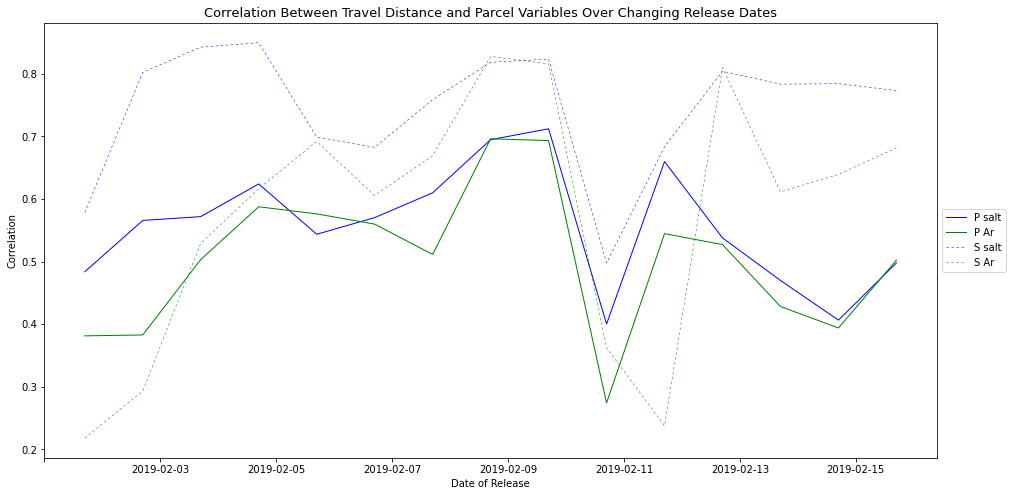

In [12]:
ParticleCorrs = pd.read_csv("Correlation Record.csv")
print(ParticleCorrs['Variable'].unique())

mask = (ParticleCorrs['Date Of Release'] >= '2019-02-02') & (ParticleCorrs['Date Of Release'] <= '2019-02-16')
# create new object with these dates 
ParticleCorrs = ParticleCorrs.loc[mask]

salt22 = ParticleCorrs[(ParticleCorrs.Variable == "salt")]
Ar22 = ParticleCorrs[(ParticleCorrs.Variable == "Ar")]
pH22 = ParticleCorrs[(ParticleCorrs.Variable == "pH")]
CSChl22 = ParticleCorrs[(ParticleCorrs.Variable == "CSChl")]
Chl22 = ParticleCorrs[(ParticleCorrs.Variable == "Chl")]
DIC22 = ParticleCorrs[(ParticleCorrs.Variable == "DIC")]


# # make figure 
fig, ax = plt.subplots(figsize = (16, 8))
# plt.yscale("log")

plt.plot('Date Of Release', 'Pearsons Correlation', data = salt22, color = 'b', linewidth = 1, label = 'P salt')
plt.plot('Date Of Release', 'Pearsons Correlation', data = Ar22, color = 'g', linewidth = 1, label = 'P Ar')
# plt.plot('Date Of Release', 'Pearsons Correlation', data = pH22, color = 'r', linewidth = 1, label = 'PH')
# plt.plot('Date Of Release', 'Pearsons Correlation', data = CSChl22, color = 'c', linewidth = 1, label = 'CSChl')
plt.plot('Date Of Release', 'Spearmans Correlation', data = salt22, color = 'b', linewidth = 0.5, label = 'S salt', ls = (0, (5, 5)))
plt.plot('Date Of Release', 'Spearmans Correlation', data = Ar22, color = 'g', linewidth = 0.5, label= 'S Ar', ls = (0, (5, 5)))
# plt.plot('Date Of Release', 'Spearmans Correlation', data = pH22, color = 'r', linewidth = 1,ls = (0, (5, 5)))
# plt.plot('Date Of Release', 'Spearmans Correlation', data = CSChl22, color = 'c', linewidth = 1, ls = (0, (5, 5)))

ax.set(ylabel = 'Correlation',xlabel = 'Date of Release')

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 2))

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Correlation Between Travel Distance and Parcel Variables Over Changing Release Dates',
          fontsize=13
         )

# plt.savefig(f"Images/Parcel_Correlations.png",dpi=300, bbox_inches='tight')


## Graph Correlation

Using the 'Correlation Record.csv', we can graph the relationship between release date and Pearson (P) or Spearmans (S) correlation for each variable.

Salinity and Aragonite status have the strongest correlation with parcel distance, and the linearity of these relationships seem to peak between the 8th & 10th of Feb.

The effect of near shore travel of particles between the 10th & 11th of Feb is once again evident in this graph. 

In [1]:
import requests
from IPython.display import Image as IMG
from IPython.display import display

 
img0 = IMG('Particles_Ar_02_02.png', width = 800)
img1 = IMG('Particles_Ar_02_09.png', width = 800)
img2 = IMG('Particles_Ar_02_16.png', width = 800)


img = display(img0,img1,img2)

## Comparison of Passive Tracing Maps

If we compare the trajectory of the flood plume at a week prior and a week after the 9th of Feb with the tracjectory at the peak of the flood, the conrast highlights the influence of the flood on the penetration of the plume into the mid shelf of the reef.

By comparison, Passive Tracing releases on thew 2/2/19 & 16/2/19 do not undergo the same penetration and are confined to the lagoon.

In [2]:
import requests
from IPython.display import Image as IMG
from IPython.display import display
 
img0 = IMG('Distance_Ar_02_02.png', width = 800)
img1 = IMG('Distance_Ar_02_09.png', width = 800)
img2 = IMG('Distance_Ar_02_16.png', width = 800)  

img = display(img0,img1,img2)

## Comparison of Relationship with Distance

If we compare the mixing of the parcels at a week prior and a week after the 9th of Feb with mixing at the peak of the flood, the contrast highlights the reduced rate of mixing during the flood event. Taking into account the previous comparison, this is the period the flood plume is penetrating deepest into the mid shelf region of the GBR.

Note the effects of near shore parcel travel on the parcel values released 16/02/2019

In [6]:
import os
import shutil
from PIL import Image  # To create gifs

# use matplotly to make the plots 
from matplotlib import pyplot as plt

# set as inline so we can see the plots as we work 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

feb_days = ['02',
            '03',
            '04',
            '05',
            '06',
            '07',
            '08',
            '09',
            '10',
            '11',
            '12',
            '13',
            '14',
            '15',
            '16']

frames = []
    
for k in feb_days:
    new_frame = Image.open('Distance_Ar_02_'+k+'.png')
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('14d_Distance_Ar_Parcels.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=2000, loop=0)

## Compiling Visual Iterations

To view iterations over release dates and variables we can compile them into .gif files which helps to visualize the progression of the flood plume